## SST Variance at different timescales??

Variance = $\overline{\Theta^2 - \overline{\Theta}^2} = \overline{(\Theta+\Theta')^2 - \overline{\Theta}^2} = \overline{\Theta'^2}$

$\overline{\Theta'^2} = \frac{1}{\Delta t} \int_0^t (\Theta(t') - \overline{\Theta})^2dt'$

So 1-10 day contribution of variance is
$ (\Theta_{1day}-\Theta_{10 day})^2$.mean('time') 

10 day is running average. What about 2 monthly? Can that just be the corresponding 2 month section, or must I calculate a running average over 60 days with daily output?

$ (\Theta_{10day}-\Theta_{2 month})^2$.mean('time') 

Or, save $\overline{\Theta^2}$ and $\overline{\Theta}$ for every overline? (Second one is the same for all though...)

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram


In [2]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37935,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:40937,Total threads: 2
Dashboard: /proxy/44799/status,Memory: 31.25 GiB
Nanny: tcp://127.0.0.1:41333,


## Load temperature (ocean_month,daily) for 10 years of 0.25

In [3]:
# files:
base = '/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/';
xch = 1440#2*288
ych = 1080#2*216

fgrd   = xr.open_dataset(base + 'output096/ocean/ocean_grid.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch,'xu_ocean':xch})
fwmass_mean = xr.open_mfdataset('/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/output096-105_mean/ocean_wmass_mean_v2test.nc').chunk({'grid_yt_ocean':ych,'grid_yu_ocean':ych,'grid_xt_ocean':xch})
fmonth_mean = xr.open_mfdataset('/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/output096-105_mean/ocean_month_mean.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch})
fheat_mean = xr.open_mfdataset('/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/output096-105_mean/ocean_heat_mean.nc').chunk({'yt_ocean':ych,'xt_ocean':xch})

# load RYF sc data
base_msc = '/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/output096-105_mean/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fmonth_sc = xr.open_mfdataset(base_msc+'ocean_month.ncea.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_sc = xr.open_mfdataset(base_msc+'ocean_heat.ncea.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_sc = xr.open_mfdataset(base_msc+'ocean_wmass.ncea.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})
fwmass_mix_sc = xr.open_mfdataset(base_msc+'ocean_wmass_diff_cbt.ncea.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

In [4]:
%%time
#### load output of monthly data for 8 years (RYF) #### output 086-094
base_msc = '/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
nr_outputs = 1   # define number of output files to consider
last_output = 96  # the last output to consider loading in
# ---------------------------------------------------------------------------------- #
a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
s = list(range(0,nr_outputs))
c = [] # empty list which I fill up
d = []
e = []
for i in s: # loop through the number of files I would like
    #c.append(i)
    d.append(i)
    e.append(i)
    # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
    #c[i] = base_msc+'output'+str(a[i]).zfill(3) + '/ocean/ocean_wmass.nc' 
    d[i] = base_msc+'output'+str(a[i]).zfill(3) + '/ocean/ocean_daily.nc' 
    e[i] = base_msc+'output'+str(a[i]).zfill(3) + '/ocean/ocean_month.nc' 

# load in data set ----------------------------------------------------------------- #
#fwmass_m = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_yu_ocean':ych/10,'grid_xt_ocean':xch/10})
fdaily = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/20,'xt_ocean':xch/20})
fmonth_m1 = xr.open_mfdataset(e,combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/20,'yu_ocean':ych/20,'xt_ocean':xch/20})


CPU times: user 5.97 s, sys: 241 ms, total: 6.21 s
Wall time: 6.97 s


In [5]:
%%time
#### load output of monthly data for 8 years (RYF) #### output 086-094
base_msc = '/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
nr_outputs = 10   # define number of output files to consider
last_output = 105  # the last output to consider loading in
# ---------------------------------------------------------------------------------- #
a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
s = list(range(0,nr_outputs))
c = [] # empty list which I fill up
d = []
e = []
for i in s: # loop through the number of files I would like
    #c.append(i)
    #d.append(i)
    e.append(i)
    # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
    #c[i] = base_msc+'output'+str(a[i]).zfill(3) + '/ocean/ocean_wmass.nc' 
    #d[i] = base_msc+'output'+str(a[i]).zfill(3) + '/ocean/ocean_daily.nc' 
    e[i] = base_msc+'output'+str(a[i]).zfill(3) + '/ocean/ocean_month.nc' 

# load in data set ----------------------------------------------------------------- #
#fwmass_m = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_yu_ocean':ych/10,'grid_xt_ocean':xch/10})
#fdaily = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/20,'xt_ocean':xch/20})
fmonth_m = xr.open_mfdataset(e,combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/20,'yu_ocean':ych/20,'xt_ocean':xch/20})


CPU times: user 4.23 s, sys: 161 ms, total: 4.39 s
Wall time: 4.98 s


In [6]:

# Generate xgcm grid object:
gridmn = Grid(fmonth_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridd = Grid(fdaily,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
grid2 = Grid(fgrd,coords={"x":{"center":"xt_ocean","right":"xu_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"}},periodic=False)

# ---------------------------------------------------------------------------------- #

# Some constants:
Cp = 3992.10322329649
rho0 = 1035

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy = gridmn.diff(fgrd.yu_ocean,'y',boundary='extend').rename({'yt_ocean':'grid_yt_ocean'})
dx = grid2.diff(fgrd.xu_ocean,'x',boundary='extend').rename({'xt_ocean':'grid_xt_ocean'})

In [7]:
def running_av_2mos(variable):
    month_length = variable.time.dt.days_in_month
    running_mean = (variable*month_length).roll(time = 1, roll_coords = False)+ (variable*month_length)#.roll(time = -1, roll_coords = False)+2*(variable*month_length)
    time_length = (month_length).roll(time = 1, roll_coords = False)+ (month_length)#.roll(time = -1, roll_coords = False)+2*(month_length)
    running_mean = running_mean/time_length
    return running_mean


In [8]:
def running_av_2mos_mo(variable):
    month_length = variable.time.dt.days_in_month
    time_length = (month_length).roll(time = 1, roll_coords = False)+ (month_length)#.roll(time = -1, roll_coords = False)+2*(month_length)
    time_length = time_length/2
    return time_length


In [9]:
def running_av_10days(variable):
    running_mean = (variable).roll(time = 1, roll_coords = False)+ (variable) + (variable).roll(time = 2, roll_coords = False)+ (variable).roll(time = 3, roll_coords = False)+(variable).roll(time = 4, roll_coords = False)+(variable).roll(time = 5, roll_coords = False)+(variable).roll(time = 6, roll_coords = False)+(variable).roll(time = 7, roll_coords = False)+(variable).roll(time = 8, roll_coords = False)+(variable).roll(time = 9, roll_coords = False)#.roll(time = -1, roll_coords = False)+2*(variable*month_length)
    running_mean = running_mean/10
    return running_mean


In [10]:
def running_av_60days(variable):
    running_mean = (variable).roll(time = 1, roll_coords = False)+ (variable) + (variable).roll(time = 2, roll_coords = False)+ \
                (variable).roll(time = 3, roll_coords = False)+(variable).roll(time = 4, roll_coords = False)+(variable).roll(time = 5, roll_coords = False)+\
                (variable).roll(time = 6, roll_coords = False)+(variable).roll(time = 7, roll_coords = False)+(variable).roll(time = 8, roll_coords = False)+\
                (variable).roll(time = 9, roll_coords = False)+(variable).roll(time = 10, roll_coords = False)+(variable).roll(time = 11, roll_coords = False)+\
                (variable).roll(time = 12, roll_coords = False)+(variable).roll(time = 13, roll_coords = False)+(variable).roll(time = 14, roll_coords = False)+\
                (variable).roll(time = 15, roll_coords = False)+(variable).roll(time = 16, roll_coords = False)+(variable).roll(time = 17, roll_coords = False)+\
                (variable).roll(time = 18, roll_coords = False)+(variable).roll(time = 19, roll_coords = False)+(variable).roll(time = 20, roll_coords = False)+\
                (variable).roll(time = 21, roll_coords = False)+(variable).roll(time = 22, roll_coords = False)+(variable).roll(time = 23, roll_coords = False)+\
                (variable).roll(time = 24, roll_coords = False)+(variable).roll(time = 25, roll_coords = False)+(variable).roll(time = 26, roll_coords = False)+\
                (variable).roll(time = 27, roll_coords = False)+(variable).roll(time = 28, roll_coords = False)+(variable).roll(time = 29, roll_coords = False)+\
                (variable).roll(time = 30, roll_coords = False)+(variable).roll(time = 31, roll_coords = False)+(variable).roll(time = 32, roll_coords = False)+\
                (variable).roll(time = 33, roll_coords = False)+(variable).roll(time = 34, roll_coords = False)+(variable).roll(time = 35, roll_coords = False)+\
                (variable).roll(time = 36, roll_coords = False)+(variable).roll(time = 37, roll_coords = False)+(variable).roll(time = 38, roll_coords = False)+\
                (variable).roll(time = 39, roll_coords = False)+(variable).roll(time = 40, roll_coords = False)+(variable).roll(time = 41, roll_coords = False)+\
                (variable).roll(time = 42, roll_coords = False)+(variable).roll(time = 43, roll_coords = False)+(variable).roll(time = 44, roll_coords = False)+\
                (variable).roll(time = 45, roll_coords = False)+(variable).roll(time = 46, roll_coords = False)+(variable).roll(time = 47, roll_coords = False)+\
                (variable).roll(time = 48, roll_coords = False)+(variable).roll(time = 49, roll_coords = False)+(variable).roll(time = 50, roll_coords = False)+\
                (variable).roll(time = 51, roll_coords = False)+(variable).roll(time = 52, roll_coords = False)+(variable).roll(time = 53, roll_coords = False)+\
                (variable).roll(time = 54, roll_coords = False)+(variable).roll(time = 55, roll_coords = False)+(variable).roll(time = 56, roll_coords = False)+\
                (variable).roll(time = 57, roll_coords = False)+(variable).roll(time = 58, roll_coords = False)+(variable).roll(time = 59, roll_coords = False)

    running_mean = running_mean/60
    return running_mean


In [11]:
fdaily['temp_10days']=running_av_10days(fdaily.temp)
fdaily['temp_60days']=running_av_60days(fdaily.temp)

fmonth_m['temp_2mo']=running_av_2mos(fmonth_m.temp)
fmonth_m1['temp_2mo']=running_av_2mos(fmonth_m1.temp)
fmonth_sc['temp_2mo']=running_av_2mos(fmonth_sc.temp)


In [12]:
# seasonal variance

In [13]:
sc_daylength_2mo = (sc_daylength+np.roll(sc_daylength,1))/2
sc_daylength_2mo

array([31. , 29.5, 29.5, 30.5, 30.5, 30.5, 30.5, 31. , 30.5, 30.5, 30.5,
       30.5])

doing timestep 1 of 12
doing timestep 2 of 12
doing timestep 3 of 12
doing timestep 4 of 12
doing timestep 5 of 12
doing timestep 6 of 12
doing timestep 7 of 12
doing timestep 8 of 12
doing timestep 9 of 12
doing timestep 10 of 12
doing timestep 11 of 12
doing timestep 12 of 12
CPU times: user 24.5 s, sys: 3.04 s, total: 27.5 s
Wall time: 2min 9s


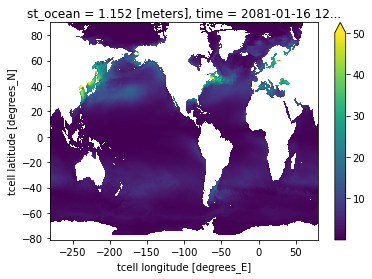

In [14]:
%%time
var_seasonal = (fmonth_sc.temp_2mo.isel(st_ocean = 0) - fmonth_mean.temp.isel(st_ocean = 0))**2
var_seasonal_mean = var_seasonal.isel(time = 0)
nt = len(var_seasonal.time)
for i in range(nt):
    print('doing timestep '+str(i+1)+' of '+str(nt))
    var_seasonal_i = var_seasonal.isel(time = i)
    var_seasonal_i.load()
    var_seasonal_mean += var_seasonal_i*sc_daylength_2mo[i]
var_seasonal_mean = var_seasonal_mean/365
var_seasonal_mean.plot(vmax = 50)
var_seasonal_mean_025 = var_seasonal_mean

In [13]:
## 2month - seasonal

In [14]:
month_lengths = (sc_daylength + np.roll(sc_daylength,1))/2
month_lengths = np.tile(month_lengths,10)
month_lengths

array([31. , 29.5, 29.5, 30.5, 30.5, 30.5, 30.5, 31. , 30.5, 30.5, 30.5,
       30.5, 31. , 29.5, 29.5, 30.5, 30.5, 30.5, 30.5, 31. , 30.5, 30.5,
       30.5, 30.5, 31. , 29.5, 29.5, 30.5, 30.5, 30.5, 30.5, 31. , 30.5,
       30.5, 30.5, 30.5, 31. , 29.5, 29.5, 30.5, 30.5, 30.5, 30.5, 31. ,
       30.5, 30.5, 30.5, 30.5, 31. , 29.5, 29.5, 30.5, 30.5, 30.5, 30.5,
       31. , 30.5, 30.5, 30.5, 30.5, 31. , 29.5, 29.5, 30.5, 30.5, 30.5,
       30.5, 31. , 30.5, 30.5, 30.5, 30.5, 31. , 29.5, 29.5, 30.5, 30.5,
       30.5, 30.5, 31. , 30.5, 30.5, 30.5, 30.5, 31. , 29.5, 29.5, 30.5,
       30.5, 30.5, 30.5, 31. , 30.5, 30.5, 30.5, 30.5, 31. , 29.5, 29.5,
       30.5, 30.5, 30.5, 30.5, 31. , 30.5, 30.5, 30.5, 30.5, 31. , 29.5,
       29.5, 30.5, 30.5, 30.5, 30.5, 31. , 30.5, 30.5, 30.5, 30.5])

In [15]:
np.sum(month_lengths)

3650.0

doing timestep 1 of 120
doing timestep 2 of 120
doing timestep 3 of 120
doing timestep 4 of 120
doing timestep 5 of 120
doing timestep 6 of 120
doing timestep 7 of 120
doing timestep 8 of 120
doing timestep 9 of 120
doing timestep 10 of 120
doing timestep 11 of 120
doing timestep 12 of 120
doing timestep 13 of 120
doing timestep 14 of 120
doing timestep 15 of 120
doing timestep 16 of 120
doing timestep 17 of 120
doing timestep 18 of 120
doing timestep 19 of 120
doing timestep 20 of 120
doing timestep 21 of 120
doing timestep 22 of 120
doing timestep 23 of 120
doing timestep 24 of 120
doing timestep 25 of 120
doing timestep 26 of 120
doing timestep 27 of 120
doing timestep 28 of 120
doing timestep 29 of 120
doing timestep 30 of 120
doing timestep 31 of 120
doing timestep 32 of 120
doing timestep 33 of 120
doing timestep 34 of 120
doing timestep 35 of 120
doing timestep 36 of 120
doing timestep 37 of 120
doing timestep 38 of 120
doing timestep 39 of 120
doing timestep 40 of 120
doing tim

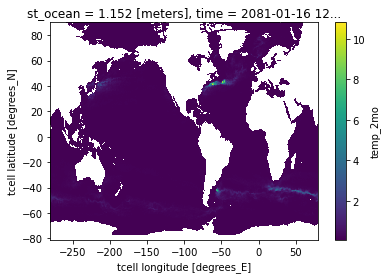

In [16]:
%%time
var_lt = fmonth_m.temp_2mo.isel(st_ocean = 0) #- fmonth_sc.temp_2mo.isel(st_ocean = 0))**2
var_lt_mean = var_lt.isel(time = 0)
nt = len(var_lt.time)
for i in range(nt):
    print('doing timestep '+str(i+1)+' of '+str(nt))
    var_lt_i = (var_lt.isel(time = i) - fmonth_sc.temp_2mo.isel(st_ocean = 0).isel(time = i%12))**2
    var_lt_i.load()
    var_lt_mean += var_lt_i*month_lengths[i]
var_lt_mean = var_lt_mean/3650
var_lt_mean.plot()

In [17]:
#save to ncfile
ds = xr.Dataset({'var_lt_mean': var_lt_mean})
                 
ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096_3d/sc_to_2mo_variance.nc', 
         encoding={'var_lt_mean': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [18]:
# one year output - 10 days to 2 months (find equivalent month given central time)

In [19]:
fdaily.temp_10days.isel(st_ocean = 0).isel(time = 50).time.dt.month.values

array(2)

doing timestep 1 of 365
doing timestep 2 of 365
doing timestep 3 of 365
doing timestep 4 of 365
doing timestep 5 of 365
doing timestep 6 of 365
doing timestep 7 of 365
doing timestep 8 of 365
doing timestep 9 of 365
doing timestep 10 of 365
doing timestep 11 of 365
doing timestep 12 of 365
doing timestep 13 of 365
doing timestep 14 of 365
doing timestep 15 of 365
doing timestep 16 of 365
doing timestep 17 of 365
doing timestep 18 of 365
doing timestep 19 of 365
doing timestep 20 of 365
doing timestep 21 of 365
doing timestep 22 of 365
doing timestep 23 of 365
doing timestep 24 of 365
doing timestep 25 of 365
doing timestep 26 of 365
doing timestep 27 of 365
doing timestep 28 of 365
doing timestep 29 of 365
doing timestep 30 of 365
doing timestep 31 of 365
doing timestep 32 of 365
doing timestep 33 of 365
doing timestep 34 of 365
doing timestep 35 of 365
doing timestep 36 of 365
doing timestep 37 of 365
doing timestep 38 of 365
doing timestep 39 of 365
doing timestep 40 of 365
doing tim

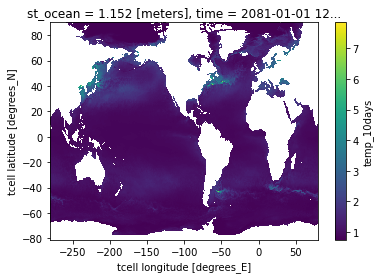

In [20]:
%%time
var_2mo = fdaily.temp_10days.isel(st_ocean = 0)
var_2mo_mean = var_2mo.isel(time = 0)
nt = len(var_2mo.time)
for i in range(nt):
    print('doing timestep '+str(i+1)+' of '+str(nt))
    var_2mo_i = var_2mo.isel(time = i)
    month = var_2mo_i.time.dt.month.values -1
    var_2mo_i = (var_2mo_i-fmonth_m.temp_2mo.isel(st_ocean = 0).isel(time = month))**2
    var_2mo_i.load()
    var_2mo_mean += var_2mo_i
var_2mo_mean = var_2mo_mean/nt
var_2mo_mean.plot()

In [21]:
#save to ncfile
ds = xr.Dataset({'var_2mo_mean': var_2mo_mean})
                 
ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096_3d/10day2mo_variance.nc', 
         encoding={'var_2mo_mean': {'shuffle': True, 'zlib': True, 'complevel': 5}})

## 60 day running mean

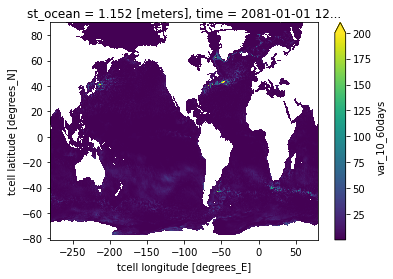

In [37]:
test = xr.open_dataarray('/scratch/e14/cy8964/temp/025deg_096_3d/60day_variance_mo0_centered.nc')
test.plot(vmax = 200)

In [12]:
fdaily['temp_10days_s']=running_av_10days(fdaily.temp.isel(st_ocean = 0))
fdaily['temp_60days_s']=running_av_60days(fdaily.temp.isel(st_ocean = 0))


In [13]:
%%time

## try with centered 60 day avg?
#temp_detrended = fdaily1d1y.temp.isel(st_ocean = 0) - clim
#fdaily1d1y_temp_10days_dt=running_av_10days(temp_detrended)
#fdaily1d1y_temp_60days_dt=running_av_60days(temp_detrended)

var_10_60days = (fdaily.temp_10days_s - fdaily.temp_60days_s.roll(time = -25, roll_coords = False))**2
var_10_60days_mean = var_10_60days.isel(time = 0)
for k in np.arange(3,12):
    if k ==11:
        var_10_60days_k = var_10_60days.isel(time = np.arange(k*30,k*30+35))
    else:
        var_10_60days_k = var_10_60days.isel(time = np.arange(k*30,k*30+30))
        
    nt = len(var_10_60days_k.time)
    var_10_60days_mean = var_10_60days.isel(time = 0)
    for i in range(nt):
        print('doing timestep '+str(i+1)+' of '+str(nt))
        var_10_60days_i = var_10_60days_k.isel(time = i)
        var_10_60days_i.load()
        var_10_60days_mean += var_10_60days_i
    var_10_60days_mean.load()
    ds = xr.Dataset({'var_10_60days': var_10_60days_mean})
    ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096_3d/60day_variance'+'_mo'+str(k)+'_centered.nc', 
                 encoding={'var_10_60days': {'shuffle': True, 'zlib': True, 'complevel': 5}})



doing timestep 1 of 30
doing timestep 2 of 30
doing timestep 3 of 30
doing timestep 4 of 30
doing timestep 5 of 30
doing timestep 6 of 30
doing timestep 7 of 30
doing timestep 8 of 30
doing timestep 9 of 30
doing timestep 10 of 30
doing timestep 11 of 30
doing timestep 12 of 30
doing timestep 13 of 30
doing timestep 14 of 30
doing timestep 15 of 30
doing timestep 16 of 30
doing timestep 17 of 30
doing timestep 18 of 30
doing timestep 19 of 30
doing timestep 20 of 30
doing timestep 21 of 30
doing timestep 22 of 30
doing timestep 23 of 30
doing timestep 24 of 30
doing timestep 25 of 30
doing timestep 26 of 30
doing timestep 27 of 30
doing timestep 28 of 30
doing timestep 29 of 30
doing timestep 30 of 30
doing timestep 1 of 30
doing timestep 2 of 30
doing timestep 3 of 30
doing timestep 4 of 30
doing timestep 5 of 30
doing timestep 6 of 30
doing timestep 7 of 30
doing timestep 8 of 30
doing timestep 9 of 30
doing timestep 10 of 30
doing timestep 11 of 30
doing timestep 12 of 30
doing time

<xarray.DataArray 'var_10_60days' (yt_ocean: 1080, xt_ocean: 1440)>
[1555200 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    st_ocean  float64 ...
    time      object ...
<xarray.DataArray 'var_10_60days' (yt_ocean: 1080, xt_ocean: 1440)>
[1555200 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    time      object ...
<xarray.DataArray 'var_10_60days' (yt_ocean: 1080, xt_ocean: 1440)>
[1555200 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    time      object ...
<xarray.DataArray 'var_10_60days' (yt_ocean: 1080, xt_ocean: 1440)>
[1555200 values with dty

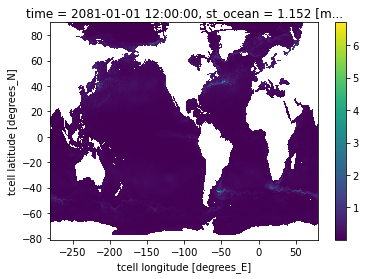

In [16]:
%%time
var_10_60days = (fdaily.temp_10days_s - fdaily.temp_60days_s.roll(time = -25, roll_coords = False))**2
var_10_60days_mean = var_10_60days.isel(time = 0)
for k in np.arange(12):
    if k ==11:
        ml = 35
    else:
        ml = 30
    var_10_60days_i = xr.open_dataarray('/scratch/e14/cy8964/temp/025deg_096_3d/60day_variance'+'_mo'+str(k)+'_centered.nc')
    print(var_10_60days_i)
    var_10_60days_i.load()
    var_10_60days_mean += var_10_60days_i#*ml
var_10_60days_mean = var_10_60days_mean/365
var_10_60days_mean.plot()

In [17]:
#save to ncfile
ds = xr.Dataset({'var_10_60days_mean': var_10_60days_mean})
                 
ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096_3d/10day60day_variance_centered.nc', 
         encoding={'var_10_60days_mean': {'shuffle': True, 'zlib': True, 'complevel': 5}})

2022-06-15 17:42:24,202 - distributed.nanny - WARNING - Restarting worker
2022-06-15 17:42:24,509 - distributed.nanny - WARNING - Restarting worker
2022-06-15 17:42:24,512 - distributed.nanny - WARNING - Restarting worker
2022-06-15 17:42:24,748 - distributed.nanny - WARNING - Restarting worker
2022-06-15 17:42:25,271 - distributed.nanny - WARNING - Restarting worker
2022-06-15 17:42:25,275 - distributed.nanny - WARNING - Restarting worker
2022-06-15 17:42:25,513 - distributed.nanny - WARNING - Restarting worker


In [ ]:
# 1 to 10 days

doing timestep 1 of 365
doing timestep 2 of 365
doing timestep 3 of 365
doing timestep 4 of 365
doing timestep 5 of 365
doing timestep 6 of 365
doing timestep 7 of 365
doing timestep 8 of 365
doing timestep 9 of 365
doing timestep 10 of 365
doing timestep 11 of 365
doing timestep 12 of 365
doing timestep 13 of 365
doing timestep 14 of 365
doing timestep 15 of 365
doing timestep 16 of 365
doing timestep 17 of 365
doing timestep 18 of 365
doing timestep 19 of 365
doing timestep 20 of 365
doing timestep 21 of 365
doing timestep 22 of 365
doing timestep 23 of 365
doing timestep 24 of 365
doing timestep 25 of 365
doing timestep 26 of 365
doing timestep 27 of 365
doing timestep 28 of 365
doing timestep 29 of 365
doing timestep 30 of 365
doing timestep 31 of 365
doing timestep 32 of 365
doing timestep 33 of 365
doing timestep 34 of 365
doing timestep 35 of 365
doing timestep 36 of 365
doing timestep 37 of 365
doing timestep 38 of 365
doing timestep 39 of 365
doing timestep 40 of 365
doing tim

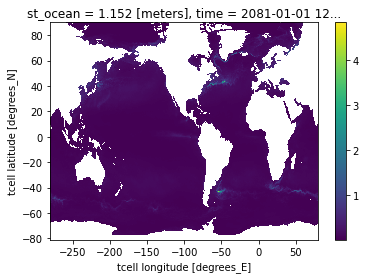

In [22]:
%%time
var_1_10days = (fdaily.temp.isel(st_ocean = 0) - fdaily.temp_10days.isel(st_ocean = 0))**2
var_1_10days_mean = var_1_10days.isel(time = 0)
nt = len(var_1_10days.time)
for i in range(nt):
    print('doing timestep '+str(i+1)+' of '+str(nt))
    var_1_10days_i = var_1_10days.isel(time = i)
    var_1_10days_i.load()
    var_1_10days_mean += var_1_10days_i
var_1_10days_mean = var_1_10days_mean/nt
var_1_10days_mean.plot()

In [23]:
#save to ncfile
ds = xr.Dataset({'var_1_10days_mean': var_1_10days_mean})
                 
ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096_3d/1to10day_variance.nc', 
         encoding={'var_1_10days_mean': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [14]:
var_1_10days_mean = xr.open_dataarray('/scratch/e14/cy8964/temp/025deg_096_3d/1to10day_variance.nc')
var_2mo_mean = xr.open_dataarray('/scratch/e14/cy8964/temp/025deg_096_3d/10day2mo_variance.nc')
var_lt_mean = xr.open_dataarray('/scratch/e14/cy8964/temp/025deg_096_3d/sc_to_2mo_variance.nc')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


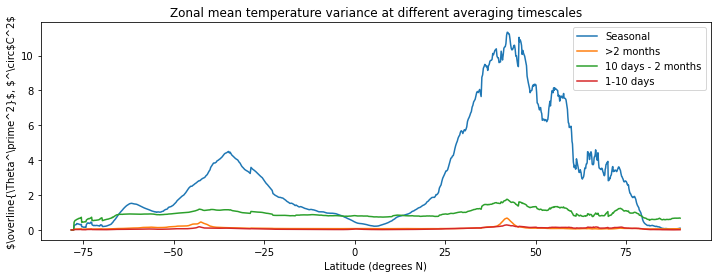

In [15]:
plt.figure(figsize = (12,4))
((var_seasonal_mean*fgrd.area_t).sum('xt_ocean')/fgrd.area_t.sum('xt_ocean')).plot(x = 'yt_ocean',label = 'Seasonal')
((var_lt_mean*fgrd.area_t).sum('xt_ocean')/fgrd.area_t.sum('xt_ocean')).plot(x = 'yt_ocean',label = '>2 months')
((var_2mo_mean*fgrd.area_t).sum('xt_ocean')/fgrd.area_t.sum('xt_ocean')).plot(x = 'yt_ocean',label = '10 days - 2 months')
((var_1_10days_mean*fgrd.area_t).sum('xt_ocean')/fgrd.area_t.sum('xt_ocean')).plot(x = 'yt_ocean',label = '1-10 days')

plt.ylabel('$\overline{\Theta^\prime^2}$, $^\circ$C^2$')
plt.title('Zonal mean temperature variance at different averaging timescales')
plt.xlabel('Latitude (degrees N)')
plt.legend()

# repeat for 1$^\circ$!

In [15]:
sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]


In [16]:
# files:
base = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/';
xch = 360*2#2*288
ych = 240*2#2*216

fgrd1d   = xr.open_dataset(base + 'output102/ocean/ocean_grid.nc').chunk({'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10,'xu_ocean':xch/10})
fmonth_mean1d = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_102_10yr/ocean_month_mean.nc').chunk({'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10})
fmonth_sc1d = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_102_10yr/ocean_month_sc.nc').chunk({'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10})
# load RYF monthly data
base_msc = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/output102/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fmonth_m1d = xr.open_mfdataset(base_msc+'ocean/ocean_month.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})

# load RYF daily data
# load RYF daily data
base_msc = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/output101/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fdaily1d1y = xr.open_mfdataset(base_msc+'ocean/ocean_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fmonth_1d1y = xr.open_mfdataset(base_msc+'ocean/ocean_month.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})

In [17]:
fdaily1d1y['temp_10days']=running_av_10days(fdaily1d1y.temp)
fmonth_1d1y['temp_2mo']=running_av_2mos(fmonth_1d1y.temp)
fmonth_m1d['temp_2mo']=running_av_2mos(fmonth_m1d.temp)
fmonth_sc1d['temp_2mo']=running_av_2mos(fmonth_sc1d.temp)
fdaily1d1y['temp_60days']=running_av_60days(fdaily1d1y.temp)


In [18]:
sc_daylength_2mo = (sc_daylength+np.roll(sc_daylength,1))/2
sc_daylength_2mo

array([31. , 29.5, 29.5, 30.5, 30.5, 30.5, 30.5, 31. , 30.5, 30.5, 30.5,
       30.5])

doing timestep 1 of 12
doing timestep 2 of 12
doing timestep 3 of 12
doing timestep 4 of 12
doing timestep 5 of 12
doing timestep 6 of 12
doing timestep 7 of 12
doing timestep 8 of 12
doing timestep 9 of 12
doing timestep 10 of 12
doing timestep 11 of 12
doing timestep 12 of 12
CPU times: user 12.8 s, sys: 1.21 s, total: 14 s
Wall time: 1min 29s


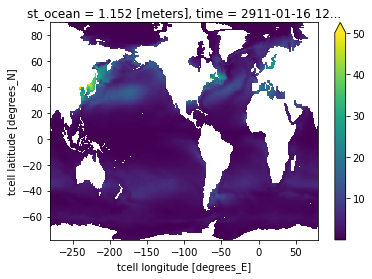

In [19]:
%%time
var_seasonal = (fmonth_sc1d.temp_2mo.isel(st_ocean = 0) - fmonth_mean1d.temp.isel(st_ocean = 0))**2
var_seasonal_mean = var_seasonal.isel(time = 0)
nt = len(var_seasonal.time)
for i in range(nt):
    print('doing timestep '+str(i+1)+' of '+str(nt))
    var_seasonal_i = var_seasonal.isel(time = i)
    var_seasonal_i.load()
    var_seasonal_mean += var_seasonal_i*sc_daylength_2mo[i]
var_seasonal_mean = var_seasonal_mean/365
var_seasonal_mean.plot(vmax = 50)
var_seasonal_mean_1 = var_seasonal_mean

In [12]:
month_lengths = (sc_daylength + np.roll(sc_daylength,1))/2
month_lengths = np.tile(month_lengths,10)
month_lengths

array([31. , 29.5, 29.5, 30.5, 30.5, 30.5, 30.5, 31. , 30.5, 30.5, 30.5,
       30.5, 31. , 29.5, 29.5, 30.5, 30.5, 30.5, 30.5, 31. , 30.5, 30.5,
       30.5, 30.5, 31. , 29.5, 29.5, 30.5, 30.5, 30.5, 30.5, 31. , 30.5,
       30.5, 30.5, 30.5, 31. , 29.5, 29.5, 30.5, 30.5, 30.5, 30.5, 31. ,
       30.5, 30.5, 30.5, 30.5, 31. , 29.5, 29.5, 30.5, 30.5, 30.5, 30.5,
       31. , 30.5, 30.5, 30.5, 30.5, 31. , 29.5, 29.5, 30.5, 30.5, 30.5,
       30.5, 31. , 30.5, 30.5, 30.5, 30.5, 31. , 29.5, 29.5, 30.5, 30.5,
       30.5, 30.5, 31. , 30.5, 30.5, 30.5, 30.5, 31. , 29.5, 29.5, 30.5,
       30.5, 30.5, 30.5, 31. , 30.5, 30.5, 30.5, 30.5, 31. , 29.5, 29.5,
       30.5, 30.5, 30.5, 30.5, 31. , 30.5, 30.5, 30.5, 30.5, 31. , 29.5,
       29.5, 30.5, 30.5, 30.5, 30.5, 31. , 30.5, 30.5, 30.5, 30.5])

doing timestep 1 of 120
doing timestep 2 of 120
doing timestep 3 of 120
doing timestep 4 of 120
doing timestep 5 of 120
doing timestep 6 of 120
doing timestep 7 of 120
doing timestep 8 of 120
doing timestep 9 of 120
doing timestep 10 of 120
doing timestep 11 of 120
doing timestep 12 of 120
doing timestep 13 of 120
doing timestep 14 of 120
doing timestep 15 of 120
doing timestep 16 of 120
doing timestep 17 of 120
doing timestep 18 of 120
doing timestep 19 of 120
doing timestep 20 of 120
doing timestep 21 of 120
doing timestep 22 of 120
doing timestep 23 of 120
doing timestep 24 of 120
doing timestep 25 of 120
doing timestep 26 of 120
doing timestep 27 of 120
doing timestep 28 of 120
doing timestep 29 of 120
doing timestep 30 of 120
doing timestep 31 of 120
doing timestep 32 of 120
doing timestep 33 of 120
doing timestep 34 of 120
doing timestep 35 of 120
doing timestep 36 of 120
doing timestep 37 of 120
doing timestep 38 of 120
doing timestep 39 of 120
doing timestep 40 of 120
doing tim

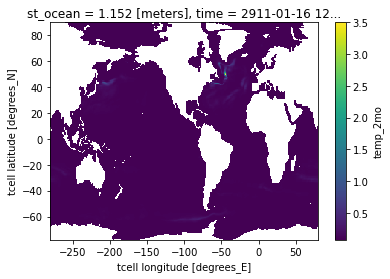

In [13]:
%%time
var_lt = fmonth_m1d.temp_2mo.isel(st_ocean = 0) #- fmonth_sc.temp_2mo.isel(st_ocean = 0))**2
var_lt_mean = var_lt.isel(time = 0)
nt = len(var_lt.time)
for i in range(nt):
    print('doing timestep '+str(i+1)+' of '+str(nt))
    var_lt_i = (var_lt.isel(time = i) - fmonth_sc1d.temp_2mo.isel(st_ocean = 0).isel(time = i%12))**2
    var_lt_i.load()
    var_lt_mean += var_lt_i*month_lengths[i]
var_lt_mean = var_lt_mean/3650
var_lt_mean.plot()

In [14]:
#save to ncfile
ds = xr.Dataset({'var_lt_mean': var_lt_mean})
                 
ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_102_10yr/sc_to_2mo_variance.nc', 
         encoding={'var_lt_mean': {'shuffle': True, 'zlib': True, 'complevel': 5}})

doing timestep 1 of 365
doing timestep 2 of 365
doing timestep 3 of 365
doing timestep 4 of 365
doing timestep 5 of 365
doing timestep 6 of 365


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-625283' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/distributed/client.py:2003> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/distributed/client.py", line 2008, in wait
    raise AllExit()
distributed.client.AllExit


doing timestep 7 of 365
doing timestep 8 of 365
doing timestep 9 of 365
doing timestep 10 of 365
doing timestep 11 of 365
doing timestep 12 of 365
doing timestep 13 of 365
doing timestep 14 of 365
doing timestep 15 of 365
doing timestep 16 of 365
doing timestep 17 of 365
doing timestep 18 of 365
doing timestep 19 of 365
doing timestep 20 of 365
doing timestep 21 of 365
doing timestep 22 of 365
doing timestep 23 of 365
doing timestep 24 of 365
doing timestep 25 of 365
doing timestep 26 of 365
doing timestep 27 of 365
doing timestep 28 of 365
doing timestep 29 of 365
doing timestep 30 of 365
doing timestep 31 of 365
doing timestep 32 of 365
doing timestep 33 of 365
doing timestep 34 of 365
doing timestep 35 of 365
doing timestep 36 of 365
doing timestep 37 of 365
doing timestep 38 of 365
doing timestep 39 of 365
doing timestep 40 of 365
doing timestep 41 of 365
doing timestep 42 of 365
doing timestep 43 of 365
doing timestep 44 of 365
doing timestep 45 of 365
doing timestep 46 of 365
doi

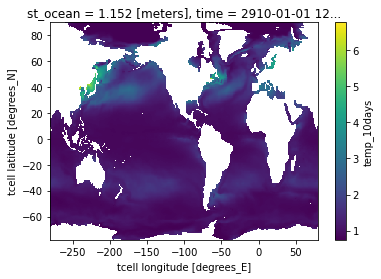

In [47]:
%%time
var_2mo = fdaily1d1y.temp_10days.isel(st_ocean = 0)
var_2mo_mean = var_2mo.isel(time = 0)
nt = len(var_2mo.time)
for i in range(nt):
    print('doing timestep '+str(i+1)+' of '+str(nt))
    var_2mo_i = var_2mo.isel(time = i)
    month = var_2mo.isel(time = i-5).time.dt.month.values -1 ###addded -5 to get in middle??
    var_2mo_i = (var_2mo_i-fmonth_1d1y.temp_2mo.isel(st_ocean = 0).isel(time = month))**2
    var_2mo_i.load()
    var_2mo_mean += var_2mo_i
var_2mo_mean = var_2mo_mean/nt
var_2mo_mean.plot()

In [48]:
var_2mo_mean_1 = var_2mo_mean

In [16]:
#save to ncfile
ds = xr.Dataset({'var_2mo_mean': var_2mo_mean})
                 
ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_102_10yr/10day2mo_variance.nc', 
         encoding={'var_2mo_mean': {'shuffle': True, 'zlib': True, 'complevel': 5}})

## 60 day running mean

Need to de-trend seasonal cycle

In [16]:
fmonth_sc.time[11]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2081, 12, 16, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 2081-12-16 12:00:00
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   NOLEAP
    bounds:          time_bounds

In [17]:
fmonth_sc_SST_dec = fmonth_sc1d.temp.isel(st_ocean = 0).isel(time = 11).assign_coords({'time':cftime.DatetimeNoLeap(2909, 12, 16, 12, 0, 0, 0, has_year_zero=True)})
fmonth_sc_SST_jan = fmonth_sc1d.temp.isel(st_ocean = 0).isel(time = 0).assign_coords({'time':cftime.DatetimeNoLeap(2911, 1, 16, 12, 0, 0, 0, has_year_zero=True)})
temp_test_2 = xr.concat([fmonth_sc_SST_dec,fmonth_sc1d.temp.assign_coords({'time':fmonth_1d1y.time}).isel(st_ocean = 0),fmonth_sc_SST_jan],dim = 'time')

In [18]:
fmonth_1d1y.time

<xarray.DataArray 'time' (time: 12)>
array([cftime.DatetimeNoLeap(2910, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2910, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2910, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2910, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2910, 5, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2910, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2910, 7, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2910, 8, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2910, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2910, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2910, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2910, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2910-01-16 12:00:00 ... 2910-12-16 12:00:00
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   NOLEAP
    bounds:          time_bounds

In [19]:
temp_test_2

<xarray.DataArray 'temp' (yt_ocean: 300, xt_ocean: 360, time: 14)>
dask.array<concatenate, shape=(300, 360, 14), dtype=float32, chunksize=(48, 72, 12), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    st_ocean  float64 1.152
  * time      (time) object 2909-12-16 12:00:00 ... 2911-01-16 12:00:00

In [20]:

clim = temp_test_2.resample(time="1D",loffset = '12H').interpolate("linear").sel(time = slice('2910-01-01','2910-12-31'))
clim.load()

<xarray.DataArray 'temp' (yt_ocean: 300, xt_ocean: 360, time: 365)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    st_ocean  float64 1.152
  * time      (time) object 2910-01-01 12:00:00 ... 2910-12-31 12:00:00

In [21]:
%%time
temp_detrended = fdaily1d1y.temp.isel(st_ocean = 0) - clim
fdaily1d1y_temp_10days_dt=running_av_10days(temp_detrended)
fdaily1d1y_temp_60days_dt=running_av_60days(temp_detrended)

var_10_60days = (fdaily1d1y_temp_10days_dt - fdaily1d1y_temp_60days_dt)**2
var_10_60days_mean = var_10_60days.isel(time = 0)
for k in np.arange(9,12):
    if k ==11:
        var_10_60days_k = var_10_60days.isel(time = np.arange(k*30,k*30+35))
    else:
        var_10_60days_k = var_10_60days.isel(time = np.arange(k*30,k*30+30))
        
    nt = len(var_10_60days_k.time)
    var_10_60days_mean = var_10_60days.isel(time = 0)
    for i in range(nt):
        print('doing timestep '+str(i+1)+' of '+str(nt))
        var_10_60days_i = var_10_60days_k.isel(time = i)
        var_10_60days_i.load()
        var_10_60days_mean += var_10_60days_i
    var_10_60days_mean.load()
    ds = xr.Dataset({'var_10_60days': var_10_60days_mean})
    ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_102_10yr/60day_variance'+'_mo'+str(k)+'_dt.nc', 
                 encoding={'var_10_60days': {'shuffle': True, 'zlib': True, 'complevel': 5}})

# var_10_60days_mean = var_10_60days_mean/nt
# var_10_60days_mean.plot()


doing timestep 1 of 30
doing timestep 2 of 30
doing timestep 3 of 30
doing timestep 4 of 30
doing timestep 5 of 30
doing timestep 6 of 30
doing timestep 7 of 30
doing timestep 8 of 30
doing timestep 9 of 30
doing timestep 10 of 30
doing timestep 11 of 30
doing timestep 12 of 30
doing timestep 13 of 30
doing timestep 14 of 30
doing timestep 15 of 30
doing timestep 16 of 30
doing timestep 17 of 30
doing timestep 18 of 30
doing timestep 19 of 30
doing timestep 20 of 30
doing timestep 21 of 30
doing timestep 22 of 30
doing timestep 23 of 30
doing timestep 24 of 30
doing timestep 25 of 30
doing timestep 26 of 30
doing timestep 27 of 30
doing timestep 28 of 30
doing timestep 29 of 30
doing timestep 30 of 30
doing timestep 1 of 30
doing timestep 2 of 30
doing timestep 3 of 30
doing timestep 4 of 30
doing timestep 5 of 30
doing timestep 6 of 30
doing timestep 7 of 30
doing timestep 8 of 30
doing timestep 9 of 30
doing timestep 10 of 30
doing timestep 11 of 30
doing timestep 12 of 30
doing time

In [24]:
%%time

## try with centered 60 day avg?
#temp_detrended = fdaily1d1y.temp.isel(st_ocean = 0) - clim
#fdaily1d1y_temp_10days_dt=running_av_10days(temp_detrended)
#fdaily1d1y_temp_60days_dt=running_av_60days(temp_detrended)

var_10_60days = (fdaily1d1y.temp_10days - fdaily1d1y.temp_60days.roll(time = -25, roll_coords = False))**2
var_10_60days_mean = var_10_60days.isel(time = 0)
for k in np.arange(12):
    if k ==11:
        var_10_60days_k = var_10_60days.isel(time = np.arange(k*30,k*30+35))
    else:
        var_10_60days_k = var_10_60days.isel(time = np.arange(k*30,k*30+30))
        
    nt = len(var_10_60days_k.time)
    var_10_60days_mean = var_10_60days.isel(time = 0)
    for i in range(nt):
        print('doing timestep '+str(i+1)+' of '+str(nt))
        var_10_60days_i = var_10_60days_k.isel(time = i)
        var_10_60days_i.load()
        var_10_60days_mean += var_10_60days_i
    var_10_60days_mean.load()
    ds = xr.Dataset({'var_10_60days': var_10_60days_mean})
    ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_102_10yr/60day_variance'+'_mo'+str(k)+'_centered.nc', 
                 encoding={'var_10_60days': {'shuffle': True, 'zlib': True, 'complevel': 5}})

# var_10_60days_mean = var_10_60days_mean/nt
# var_10_60days_mean.plot()


doing timestep 1 of 30
doing timestep 2 of 30
doing timestep 3 of 30
doing timestep 4 of 30
doing timestep 5 of 30
doing timestep 6 of 30
doing timestep 7 of 30
doing timestep 8 of 30
doing timestep 9 of 30
doing timestep 10 of 30
doing timestep 11 of 30
doing timestep 12 of 30
doing timestep 13 of 30
doing timestep 14 of 30
doing timestep 15 of 30
doing timestep 16 of 30
doing timestep 17 of 30
doing timestep 18 of 30
doing timestep 19 of 30
doing timestep 20 of 30
doing timestep 21 of 30
doing timestep 22 of 30
doing timestep 23 of 30
doing timestep 24 of 30
doing timestep 25 of 30
doing timestep 26 of 30
doing timestep 27 of 30
doing timestep 28 of 30
doing timestep 29 of 30
doing timestep 30 of 30
doing timestep 1 of 30
doing timestep 2 of 30
doing timestep 3 of 30
doing timestep 4 of 30
doing timestep 5 of 30
doing timestep 6 of 30
doing timestep 7 of 30
doing timestep 8 of 30
doing timestep 9 of 30
doing timestep 10 of 30
doing timestep 11 of 30
doing timestep 12 of 30
doing time

<xarray.DataArray 'var_10_60days' (yt_ocean: 300, xt_ocean: 360)>
[108000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    st_ocean  float64 1.152
    time      object ...
<xarray.DataArray 'var_10_60days' (yt_ocean: 300, xt_ocean: 360)>
[108000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    st_ocean  float64 1.152
    time      object ...
<xarray.DataArray 'var_10_60days' (yt_ocean: 300, xt_ocean: 360)>
[108000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    st_ocean  float64 1.152
    time      object ...
<xarray.DataArray 'var_10_60day

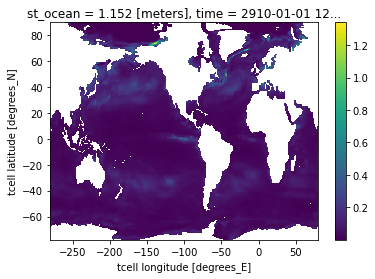

In [29]:
%%time
var_10_60days = (fdaily1d1y.temp_10days.isel(st_ocean = 0) - fdaily1d1y.temp_60days.isel(st_ocean = 0).roll(time = -25, roll_coords = False))**2
var_10_60days_mean = var_10_60days.isel(time = 0)
for k in np.arange(12):
    if k ==11:
        ml = 35
    else:
        ml = 30
    var_10_60days_i = xr.open_dataarray('/scratch/e14/cy8964/temp/1deg_102_10yr/60day_variance'+'_mo'+str(k)+'_centered.nc').isel(st_ocean = 0)
    print(var_10_60days_i)
    var_10_60days_i.load()
    var_10_60days_mean += var_10_60days_i#*ml
var_10_60days_mean = var_10_60days_mean/365
var_10_60days_mean.plot()

In [30]:
#save to ncfile
ds = xr.Dataset({'var_10_60days_mean': var_10_60days_mean})
                 
ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_102_10yr/10day60day_variance_centered.nc', 
         encoding={'var_10_60days_mean': {'shuffle': True, 'zlib': True, 'complevel': 5}})

doing timestep 1 of 365
doing timestep 2 of 365
doing timestep 3 of 365
doing timestep 4 of 365
doing timestep 5 of 365
doing timestep 6 of 365
doing timestep 7 of 365
doing timestep 8 of 365
doing timestep 9 of 365
doing timestep 10 of 365
doing timestep 11 of 365
doing timestep 12 of 365
doing timestep 13 of 365
doing timestep 14 of 365
doing timestep 15 of 365
doing timestep 16 of 365
doing timestep 17 of 365
doing timestep 18 of 365
doing timestep 19 of 365
doing timestep 20 of 365
doing timestep 21 of 365
doing timestep 22 of 365
doing timestep 23 of 365
doing timestep 24 of 365
doing timestep 25 of 365
doing timestep 26 of 365
doing timestep 27 of 365
doing timestep 28 of 365
doing timestep 29 of 365
doing timestep 30 of 365
doing timestep 31 of 365
doing timestep 32 of 365
doing timestep 33 of 365
doing timestep 34 of 365
doing timestep 35 of 365
doing timestep 36 of 365
doing timestep 37 of 365
doing timestep 38 of 365
doing timestep 39 of 365
doing timestep 40 of 365
doing tim

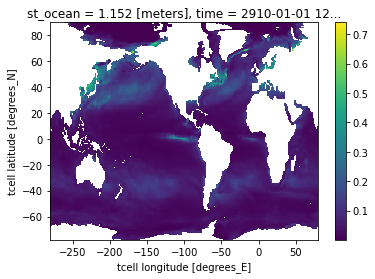

In [17]:
%%time
var_1_10days = (fdaily1d1y.temp.isel(st_ocean = 0) - fdaily1d1y.temp_10days.isel(st_ocean = 0))**2
var_1_10days_mean = var_1_10days.isel(time = 0)
nt = len(var_1_10days.time)
for i in range(nt):
    print('doing timestep '+str(i+1)+' of '+str(nt))
    var_1_10days_i = var_1_10days.isel(time = i)
    var_1_10days_i.load()
    var_1_10days_mean += var_1_10days_i
var_1_10days_mean = var_1_10days_mean/nt
var_1_10days_mean.plot()

In [18]:
#save to ncfile
ds = xr.Dataset({'var_1_10days_mean': var_1_10days_mean})
                 
ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_102_10yr/1to10day_variance.nc', 
         encoding={'var_1_10days_mean': {'shuffle': True, 'zlib': True, 'complevel': 5}})

# PLOTTING

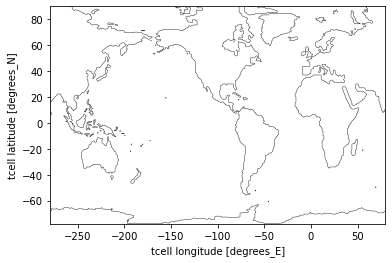

In [20]:
mask = (fgrd1d.ht.where(fgrd1d.ht>0)*0+1).fillna(0)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')

In [21]:
var_1_10days_mean_025 = xr.open_dataarray('/scratch/e14/cy8964/temp/025deg_096_3d/1to10day_variance.nc')
var_2mo_mean_025 = xr.open_dataarray('/scratch/e14/cy8964/temp/025deg_096_3d/10day60day_variance_centered.nc')
var_lt_mean_025 = xr.open_dataarray('/scratch/e14/cy8964/temp/025deg_096_3d/sc_to_2mo_variance.nc')

var_1_10days_mean_1 = xr.open_dataarray('/scratch/e14/cy8964/temp/1deg_102_10yr/1to10day_variance.nc')
var_2mo_mean_1 = xr.open_dataarray('/scratch/e14/cy8964/temp/1deg_102_10yr/10day60day_variance_centered.nc')
var_lt_mean_1 = xr.open_dataarray('/scratch/e14/cy8964/temp/1deg_102_10yr/sc_to_2mo_variance.nc')


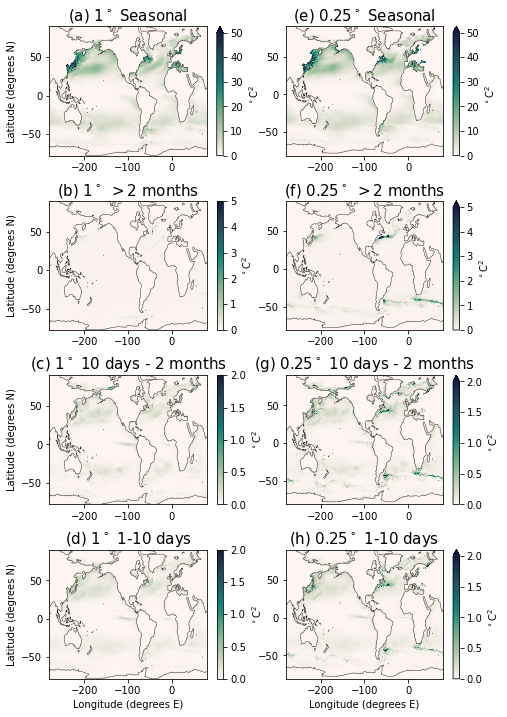

In [22]:
fig = plt.figure(figsize=(12,12),facecolor='w')
cmap = cm.cm.tempo
vmax_seasonal = 50
vmax_lt = 5
vmax_2mo = 2
vmax_day = 2

plt.subplot(4,3,1)
var_seasonal_mean_1.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 0, vmax =vmax_seasonal)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(a) 1$^\circ$ Seasonal', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('')

plt.subplot(4,3,4)
var_lt_mean_1.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 0,vmax = vmax_lt)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(b) 1$^\circ$ $>2$ months', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('')

plt.subplot(4,3,7)
var_2mo_mean_1.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 0,vmax = vmax_2mo)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(c) 1$^\circ$ 10 days - 2 months', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('')

plt.subplot(4,3,10)
var_1_10days_mean_1.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 0,vmax = vmax_day)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(d) 1$^\circ$ 1-10 days', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('Longitude (degrees E)')

plt.subplot(4,3,2)
var_seasonal_mean_025.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 0, vmax =vmax_seasonal)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(e) 0.25$^\circ$ Seasonal', fontsize = 15)
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,3,5)
var_lt_mean_025.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 0,vmax = vmax_lt)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(f) 0.25$^\circ$ $>2$ months', fontsize = 15)
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,3,8)
var_2mo_mean_025.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 0,vmax = vmax_2mo)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(g) 0.25$^\circ$ 10 days - 2 months', fontsize = 15)
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,3,11)
var_1_10days_mean_025.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 0,vmax = vmax_day)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(h) 0.25$^\circ$ 1-10 days', fontsize = 15)
plt.ylabel('')
plt.xlabel('Longitude (degrees E)')

fig.subplots_adjust(hspace = 0.35)

plt.savefig('variance_comparison.png',dpi = 200)


## I think the 10day-2 month one is due to going from a running average to monthly averaged output. Should do 60 day running mean instead....

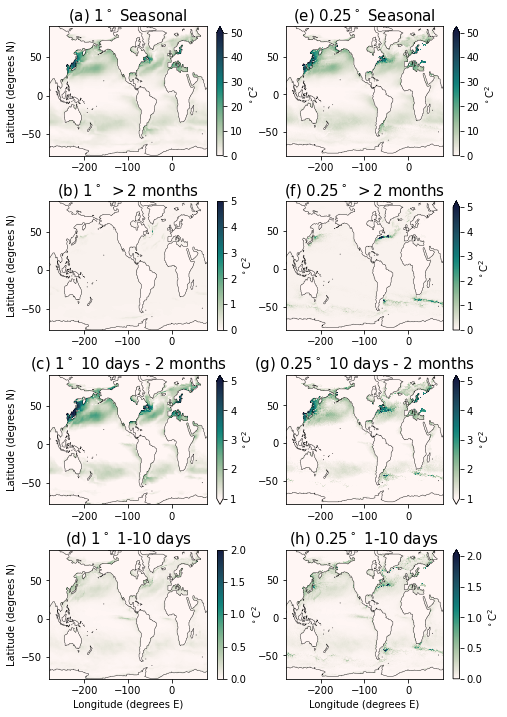

2022-06-10 16:52:17,925 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,125 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,132 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,215 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,299 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,383 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,498 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,684 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,687 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:19,151 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:19,155 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:19,239 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:19,317 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:19,393 - distributed.

In [50]:
fig = plt.figure(figsize=(12,12),facecolor='w')
cmap = cm.cm.tempo
vmax_seasonal = 50
vmax_lt = 5
vmax_2mo = 5
vmax_day = 2

plt.subplot(4,3,1)
var_seasonal_mean_1.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 0, vmax =vmax_seasonal)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(a) 1$^\circ$ Seasonal', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('')

plt.subplot(4,3,4)
var_lt_mean_1.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 0,vmax = vmax_lt)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(b) 1$^\circ$ $>2$ months', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('')

plt.subplot(4,3,7)
var_2mo_mean_1.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 1,vmax = vmax_2mo)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(c) 1$^\circ$ 10 days - 2 months', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('')

plt.subplot(4,3,10)
var_1_10days_mean_1.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 0,vmax = vmax_day)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(d) 1$^\circ$ 1-10 days', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('Longitude (degrees E)')

plt.subplot(4,3,2)
var_seasonal_mean_025.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 0, vmax =vmax_seasonal)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(e) 0.25$^\circ$ Seasonal', fontsize = 15)
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,3,5)
var_lt_mean_025.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 0,vmax = vmax_lt)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(f) 0.25$^\circ$ $>2$ months', fontsize = 15)
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,3,8)
var_2mo_mean_025.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 1,vmax = vmax_2mo)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(g) 0.25$^\circ$ 10 days - 2 months', fontsize = 15)
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,3,11)
var_1_10days_mean_025.fillna(0).plot(y='yt_ocean',cbar_kwargs={'label':'$^\circ$C$^2$'},cmap=cmap, vmin = 0,vmax = vmax_day)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(h) 0.25$^\circ$ 1-10 days', fontsize = 15)
plt.ylabel('')
plt.xlabel('Longitude (degrees E)')

fig.subplots_adjust(hspace = 0.35)


## ^^ the shorter timescales all seem to have seasonal cycle imprinted on them?? do I need to de-trend??